In [45]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Conv2D, Flatten, Dense, Rescaling
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import image_dataset_from_directory
import os, shutil, pathlib
import numpy as np
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt

## Training a convnet from scratch on a small dataset

**Copying images to training, validation, and test directories**

In [4]:
# original_dir = pathlib.Path("dogs-vs-cats/train")
# new_base_dir = pathlib.Path("cats_vs_dogs_small")

# def make_dataset_subset(folder, start_index, end_index):
    
#     for category in ("cat", "dog"):
        
#         directory = new_base_dir / folder / category
#         os.makedirs(directory)
#         fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        
#         for fname in fnames:
#             shutil.copyfile(src=original_dir / fname, dst=directory / fname)

# make_dataset_subset("train", start_index=0, end_index=1000)
# make_dataset_subset("validation", start_index=1000, end_index=1500)
# make_dataset_subset("test", start_index=1500, end_index=2500)

### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [7]:
inputs = Input(shape=(180, 180, 3))

x = Rescaling(1./255)(inputs)

x = Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = Flatten()(x)
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs=inputs, outputs=outputs)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

**Configuring the model for training**

In [9]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

### Data preprocessing

**Using `image_dataset_from_directory` to read images**

In [11]:
train_dataset = image_dataset_from_directory(new_base_dir / "train", image_size=(180, 180), batch_size=32)
validation_dataset = image_dataset_from_directory(new_base_dir / "validation", image_size=(180, 180), batch_size=32)
test_dataset = image_dataset_from_directory(new_base_dir / "test", image_size=(180, 180), batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [35]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a `Dataset`**

In [42]:
callbacks = [ModelCheckpoint(filepath="cat-dog.keras", save_best_only=True, monitor="val_loss")]
history = model.fit(train_dataset, epochs=30, validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 8s 56ms/step - loss: 0.7374 - accuracy: 0.5205 - val_loss: 0.6870 - val_accuracy: 0.5080
Epoch 2/30
63/63 [==============================] - 3s 44ms/step - loss: 0.7050 - accuracy: 0.5475 - val_loss: 0.6430 - val_accuracy: 0.6470
Epoch 3/30
63/63 [==============================] - 3s 45ms/step - loss: 0.6658 - accuracy: 0.6485 - val_loss: 0.6218 - val_accuracy: 0.6420
Epoch 4/30
63/63 [==============================] - 3s 45ms/step - loss: 0.6139 - accuracy: 0.6795 - val_loss: 0.6933 - val_accuracy: 0.6550
Epoch 5/30
63/63 [==============================] - 3s 46ms/step - loss: 0.5946 - accuracy: 0.6825 - val_loss: 0.5789 - val_accuracy: 0.6930
Epoch 6/30
63/63 [==============================] - 3s 46ms/step - loss: 0.5445 - accuracy: 0.7230 - val_loss: 0.5710 - val_accuracy: 0.7090
Epoch 7/30
63/63 [==============================] - 3s 46ms/step - loss: 0.5104 - accuracy: 0.7620 - val_loss: 0.6370 - val_accuracy: 0.7060
Epoch 8/30
63

**Displaying curves of loss and accuracy during training**

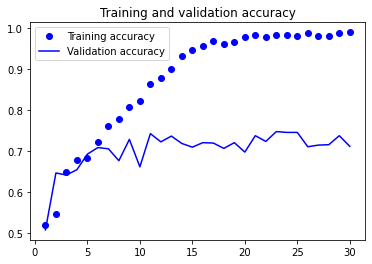

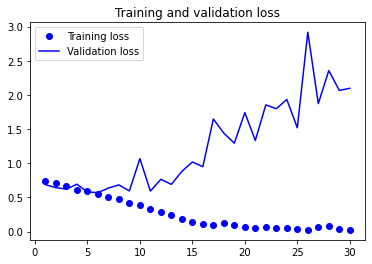

In [44]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [46]:
test_model = load_model("cat-dog.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 19ms/step - loss: 0.6055 - accuracy: 0.6910
Test accuracy: 0.691


### Using data augmentation

**Define a data augmentation stage to add to an image model**

In [0]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

In [0]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [0]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [0]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

**Evaluating the model on the test set**

In [0]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

## Leveraging a pretrained model

### Feature extraction with a pretrained model

**Instantiating the VGG16 convolutional base**

In [0]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [0]:
conv_base.summary()

#### Fast feature extraction without data augmentation

**Extracting the VGG16 features and corresponding labels**

In [0]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [0]:
train_features.shape

**Defining and training the densely connected classifier**

In [0]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

**Plotting the results**

In [0]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Feature extraction together with data augmentation

**Instantiating and freezing the VGG16 convolutional base**

In [0]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [0]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

In [0]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

**Adding a data augmentation stage and a classifier to the convolutional base**

In [0]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [0]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

**Evaluating the model on the test set**

In [0]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

### Fine-tuning a pretrained model

In [0]:
conv_base.summary()

**Freezing all layers until the fourth from the last**

In [0]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [0]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

In [0]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

## Summary